Processing: 5x41


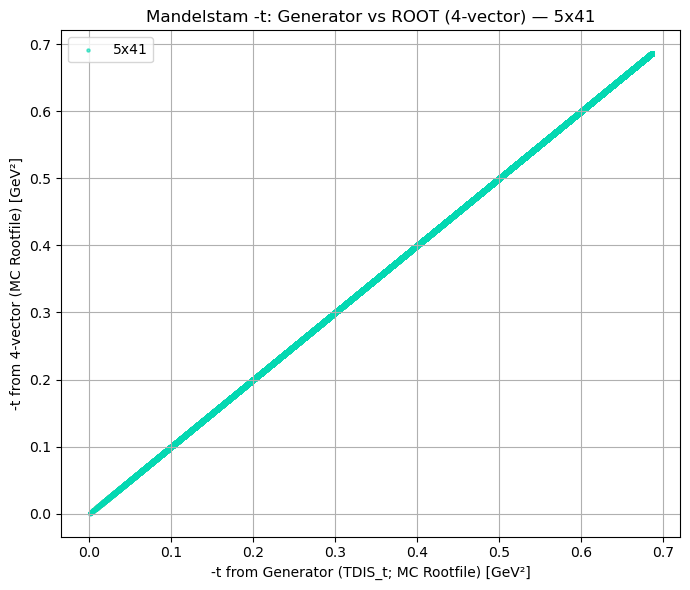

Processing: 10x100


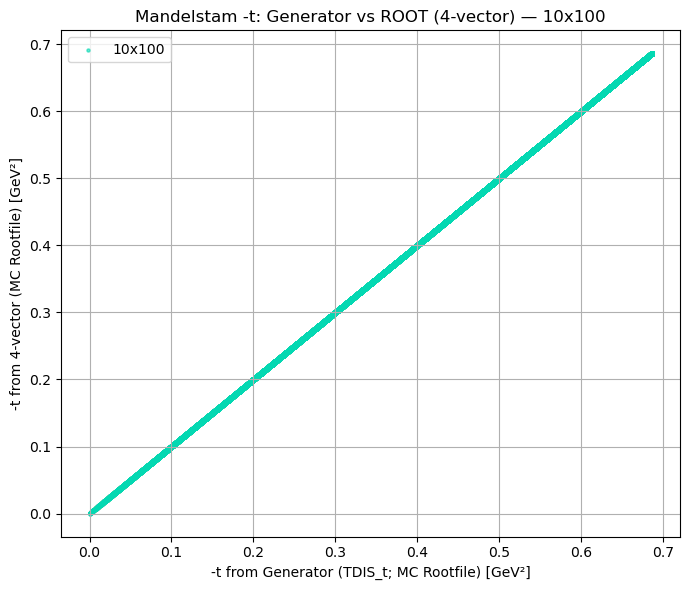

Processing: 18x275


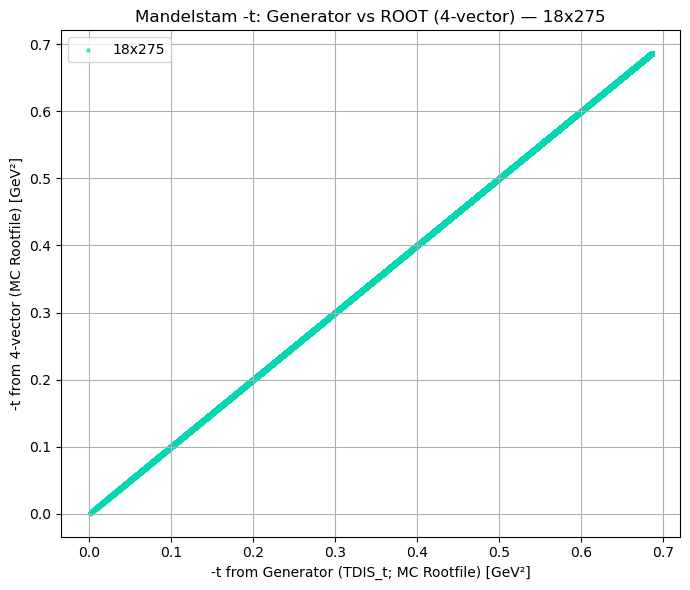

In [3]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Settings and paths
settings = ["5x41", "10x100", "18x275"]
root_dir = "/home/ubuntu/meson-structure/data/root_files/correct_E"
root_file_map = {
    "5x41": "k_lambda_crossing_25_5.0on41.0_x0.0001-0.9000_q1.0-500.0.root",
    "10x100": "k_lambda_crossing_25_10.0on100.0_x0.0001-0.9000_q1.0-500.0.root",
    "18x275": "k_lambda_crossing_25_18.0on275.0_x0.0001-0.9000_q1.0-500.0.root"
}

def mandelstam_t(p_proton, p_lambda):
    q = p_proton - p_lambda
    return q[0]**2 - np.sum(q[1:]**2)

for setting in settings:
    print(f"Processing: {setting}")
    root_file = os.path.join(root_dir, root_file_map[setting])

    with uproot.open(root_file) as f:
        tree = f["Process"]

        # Proton 4-vector
        Epr = tree["EprE_inc"].array(library="np")
        pxpr = tree["pprx_inc"].array(library="np")
        pypr = tree["ppry_inc"].array(library="np")
        pzpr = tree["pprz_inc"].array(library="np")
        p_proton = np.vstack((Epr, pxpr, pypr, pzpr)).T

        # Lambda 4-vector (MC from root)
        Elam = tree["ElambE_Lab"].array(library="np")
        pxlam = tree["plambx_Lab"].array(library="np")
        pylam = tree["plamby_Lab"].array(library="np")
        pzlam = tree["plambz_Lab"].array(library="np")
        p_lambda = np.vstack((Elam, pxlam, pylam, pzlam)).T

        # Generator t
        t_gen = tree["TDIS_t"].array(library="np")

    # Compute t from 4-vectors
    t_reco = np.array([mandelstam_t(p, l) for p, l in zip(p_proton, p_lambda)])

    # Save to DataFrame for plotting/inspection
    df = pd.DataFrame({
        "t_mc_root": t_reco,
        "t_mc_generator_value": t_gen
    })
    df.to_csv(f"t_check_root_only_{setting}.csv", index=False)

    # Plot comparison
    plt.figure(figsize=(7, 6))
    plt.scatter(-df["t_mc_generator_value"], -df["t_mc_root"], s=5, c='#04D8B2', alpha=0.6, label=setting)
    plt.xlabel("-t from Generator (TDIS_t; MC Rootfile) [GeV²]")
    plt.ylabel("-t from 4-vector (MC Rootfile) [GeV²]")
    plt.title(f"Mandelstam -t: Generator vs ROOT (4-vector) — {setting}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"t_gen_vs_root_{setting}.png")
    plt.close()
